In [1]:
import matplotlib
from datetime import datetime
import getopt
import sys
import os
import logging
from torch import nn
import matplotlib.pyplot as plt
import torch
import hydra
from pathlib import Path
from omegaconf import DictConfig, OmegaConf
import einops
import yaml

from coral.utils.data.load_data import (set_seed, get_dynamics_data)
from coral.utils.data.dynamics_dataset import TemporalDatasetWithCode, KEY_TO_INDEX
from template.ode_dynamics import DetailedMSE
from deeponet import DeepONet, AR_forward
from eval import eval_deeponet
from forwards_operator import forward_deeponet_up

/home/kassai/code/coral/template/ode_dynamics.py:54: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config/dynamics/", config_name="ode.yaml")


In [2]:
cfg = DictConfig(yaml.safe_load(open("config/deeponet.yaml")))
dataset_name = cfg.data.dataset_name

run_name = cfg.deeponet.run_name
run_name = 'star-bantha-4340'
root_dir = Path(os.getenv("WANDB_DIR")) / dataset_name

tmp = torch.load(root_dir / "deeponet" / f"{run_name}_tr.pt")
cfg = tmp['cfg']

star-bantha-4340 # 0.05
stellar-tauntaun-4341 # 0.2
grievous-fighter-4348 # 2

In [3]:
# data
data_dir = cfg.data.dir
dataset_name = cfg.data.dataset_name
ntrain = cfg.data.ntrain
ntest = cfg.data.ntest
data_to_encode = cfg.data.data_to_encode
sub_tr = cfg.data.sub_tr
sub_te = cfg.data.sub_te
seed = cfg.data.seed
same_grid = cfg.data.same_grid
seq_inter_len = cfg.data.seq_inter_len
seq_extra_len = cfg.data.seq_extra_len

# deeponet
model_type = cfg.deeponet.model_type
code_dim = 1
branch_depth = cfg.deeponet.branch_depth
trunk_depth = cfg.deeponet.trunk_depth
width = cfg.deeponet.width

# optim
batch_size = cfg.optim.batch_size
batch_size_val = (
    batch_size if cfg.optim.batch_size_val == None else cfg.optim.batch_size_val
)

multichannel = False

In [4]:
def set_requires_grad(module, tf=False):
    module.requires_grad = tf
    for param in module.parameters():
        param.requires_grad = tf

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import operator

from network import Swish


class Module(torch.nn.Module):
    '''Standard module format.'''
    def __init__(self):
        super(Module, self).__init__()
        self.activation = None
        self.initializer = None
        self.__device = None
        self.__dtype = None

    @property
    def device(self):
        return self.__device

    @property
    def dtype(self):
        return self.__dtype

    @device.setter
    def device(self, d):
        if d == 'cpu':
            self.cpu()
        elif d == 'gpu':
            self.cuda()
        else:
            raise ValueError
        self.__device = d

    @dtype.setter
    def dtype(self, d):
        if d == 'float':
            self.to(torch.float)
        elif d == 'double':
            self.to(torch.double)
        else:
            raise ValueError
        self.__dtype = d

    @property
    def Device(self):
        if self.__device == 'cpu':
            return torch.device('cpu')
        elif self.__device == 'gpu':
            return torch.device('cuda')

    @property
    def Dtype(self):
        if self.__dtype == 'float':
            return torch.float32
        elif self.__dtype == 'double':
            return torch.float64

    @property
    def act(self):
        if self.activation == 'sigmoid':
            return torch.sigmoid
        elif self.activation == 'relu':
            return torch.relu
        elif self.activation == 'tanh':
            return torch.tanh
        elif self.activation == 'elu':
            return torch.elu
        elif self.activation == 'swish':
            return Swish()
        else:
            raise NotImplementedError

    @property
    def Act(self):
        if self.activation == 'sigmoid':
            return torch.nn.Sigmoid()
        elif self.activation == 'relu':
            return torch.nn.ReLU()
        elif self.activation == 'tanh':
            return torch.nn.Tanh()
        elif self.activation == 'elu':
            return torch.nn.ELU()
        elif self.activation == 'swish':
            return Swish()
        else:
            raise NotImplementedError

    @property
    def weight_init_(self):
        if self.initializer == 'He normal':
            return torch.nn.init.kaiming_normal_
        elif self.initializer == 'He uniform':
            return torch.nn.init.kaiming_uniform_
        elif self.initializer == 'Glorot normal':
            return torch.nn.init.xavier_normal_
        elif self.initializer == 'Glorot uniform':
            return torch.nn.init.xavier_uniform_
        elif self.initializer == 'orthogonal':
            return torch.nn.init.orthogonal_
        elif self.initializer == 'default':
            if self.activation == 'relu':
                return torch.nn.init.kaiming_normal_
            elif self.activation == 'tanh':
                return torch.nn.init.orthogonal_
            else:
                return lambda x: None
        else:
            raise NotImplementedError


class StructureNN(Module):
    '''Structure-oriented neural network used as a general map based on designing architecture.'''
    def __init__(self):
        super(StructureNN, self).__init__()

    def predict(self, x, returnnp=False):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=self.Dtype, device=self.Device)
        return self(x).cpu().detach().numpy() if returnnp else self(x)


class DeepONet(StructureNN):
    '''
    Deep operator network.
    Input: [batch size, branch_dim + trunk_dim]
    Output: [batch size, 1]
    '''
    def __init__(self, branch_dim, trunk_dim, branch_depth=2, trunk_depth=3, width=50, activation='relu', logger=None, input_dataset="navier"):
        super(DeepONet, self).__init__()
        self.branch_dim = branch_dim
        self.trunk_dim = trunk_dim
        self.branch_depth = branch_depth
        self.trunk_depth = trunk_depth
        self.width = width
        self.activation = activation
        self.modus = self.__init_modules()
        self.params = self.__init_params()
        self.logger = logger
        self.is_sw = (input_dataset == "shallow-water-dino")

    def forward(self, x_branch, x_trunk):
        # X_branch = B, XY
        # X_trunk = B, XY, grid
        for i in range(1, self.trunk_depth):
            x_trunk = self.modus['TrActM{}'.format(i)](self.modus['TrLinM{}'.format(i)](x_trunk))
        # x trunk  = torch.Size([6, 4096, 250])
    
        for i in range(1, self.branch_depth):
            #  [10, 1638, 2]
            x_branch = self.modus['BrActM{}'.format(i)](self.modus['BrLinM{}'.format(i)](x_branch))
        x_branch = self.modus['BrLinM{}'.format(self.branch_depth)](x_branch)
        x_branch = x_branch.unsqueeze(dim=1).expand(x_trunk.shape)
        # X_branch = # [6, 4096, 250]

        if self.is_sw: # TODO : multichannels
            output1 = torch.sum(x_branch[:, :, :self.width // 2] * x_trunk[:, :, :self.width // 2], dim=-1, keepdim=True) + self.params['bias']
            output2 = torch.sum(x_branch[:, :, self.width // 2:] * x_trunk[:, :, self.width // 2:], dim=-1, keepdim=True) + self.params['bias2']
            output = torch.cat((output1, output2), dim=2)
        else:
            output = torch.sum(x_branch * x_trunk, dim=-1, keepdim=True) + self.params['bias'] # TODO multichannels

        return output

    def trunk_forward(self, x_trunk):
        for i in range(1, self.trunk_depth):
            x_trunk = self.modus['TrActM{}'.format(i)](self.modus['TrLinM{}'.format(i)](x_trunk))
        return x_trunk

    def branch_forward(self, x_branch):
        for i in range(1, self.branch_depth):
            print("x_branch.shape : ", x_branch.shape)
            print("self.modus['BrLinM{}'.format(i)] : ", self.modus['BrLinM{}'.format(i)])
            x_branch = self.modus['BrActM{}'.format(i)](self.modus['BrLinM{}'.format(i)](x_branch))
        x_branch = self.modus['BrLinM{}'.format(self.branch_depth)](x_branch)
        return x_branch

    def __init_modules(self):
        modules = nn.ModuleDict()
        if self.branch_depth > 1:
            modules['BrLinM1'] = nn.Linear(self.branch_dim, self.width)
            modules['BrActM1'] = self.Act
            for i in range(2, self.branch_depth):
                modules['BrLinM{}'.format(i)] = nn.Linear(self.width, self.width)
                modules['BrActM{}'.format(i)] = self.Act
            modules['BrLinM{}'.format(self.branch_depth)] = nn.Linear(self.width, self.width)
        else:
            modules['BrLinM{}'.format(self.branch_depth)] = nn.Linear(self.branch_dim, self.width)

        modules['TrLinM1'] = nn.Linear(self.trunk_dim, self.width)
        modules['TrActM1'] = self.Act
        for i in range(2, self.trunk_depth):
            modules['TrLinM{}'.format(i)] = nn.Linear(self.width, self.width)
            modules['TrActM{}'.format(i)] = self.Act
        return modules

    def __init_params(self):
        params = nn.ParameterDict()
        params['bias'] = nn.Parameter(torch.zeros([1]))
        params['bias2'] = nn.Parameter(torch.zeros([1]))
        return params


def AR_forward(deeponet, t, coords, ground_truth, logger=None, is_test=False):
    # TODO is_test à tester
    print('ok')
    if is_test:
        x_trunk_in_s = coords.reshape(*coords.shape[:1], -1, *coords.shape[-1:])
    else:
        x_trunk_in_s = coords[:, :, :]
    x_branch = ground_truth[:, :1, :, :].squeeze()  # [32, 10, 1992, 1] vs [32, 10, 1992, 2]
    # CI, on prend que le 1er pas de temps et on squeeze = B, XY, C
    if len(x_branch.shape) == 3:
        x_branch = x_branch.flatten(start_dim=1)
    for i, t in enumerate(t):
        # x_branch is B, XY
        # x_trink_in_s is B, T, XY, grid

        # X_trunk devrait etre B, XY, grid et X_branch devrait etre B, XY
        im = deeponet(x_branch, x_trunk_in_s).unsqueeze(dim=1)

        if i == 0: # manage initial condition
            if is_test:
                model_output = ground_truth.reshape(*ground_truth.shape[:2], -1, *ground_truth.shape[-1:])[:, :1, :, :]
            else:
                model_output = ground_truth[:, :1, :, :]
        else:
            model_output = torch.cat((model_output, im), dim=1)
            
    return model_output

In [6]:
def forward_deeponet_up(deeponet, images, images_up, coords, coords_up, timestamps, device):
    # flatten spatial dims
    t = timestamps.to(device)
    ground_truth = einops.rearrange(images, 'B ... C T -> B (...) C T')
    ground_truth_up = einops.rearrange(images_up, 'B ... C T -> B (...) C T')
    model_input = einops.rearrange(coords, 'B ... C T -> B (...) C T')
    model_input_up = einops.rearrange(coords_up, 'B ... C T -> B (...) C T')

    ground_truth = torch.permute(
        ground_truth, (0, 3, 1, 2)).to('cuda')  # [B, XY, C, T] -> [B, T, XY, C]
    ground_truth_up = torch.permute(
        ground_truth_up, (0, 3, 1, 2)).to('cuda')  # [B, XY, C, T] -> [B, T, XY, C]

    model_input = torch.permute(
        model_input, (0, 3, 1, 2))[:, 0, :, :].to(device)  # [B, XY, C, T] -> -> [B, T, XY, C] -> [B, XY, C]
    model_input_up = torch.permute(
        model_input_up, (0, 3, 1, 2))[:, 0, :, :].to(device)  # [B, XY, C, T] -> -> [B, T, XY, C] -> [B, XY, C]
    
    # On prend que la première grille (c'est tjs la mm dans deeponet) 
    b_size, t_size, hw_size, channels = ground_truth.shape
    # t is T, model_input is B, XY, grid, ground_truth is B, T, XY, C
    model_output = AR_forward_up(deeponet, t, model_input, model_input_up, ground_truth, ground_truth_up) 

    return model_output

def AR_forward_up(deeponet, timestamps, coords, coords_up, ground_truth, ground_truth_up, logger=None, is_test=False):
    b_size = ground_truth.shape[0]
    
    # first AR forward on original grid
    x_trunk_in_s = coords
    x_branch = ground_truth[:, :1, :, :].squeeze()  # [32, 10, 1992, 1] vs [32, 10, 1992, 2]
    if b_size == 1:
        x_branch = x_branch.unsqueeze(0)
    if len(x_branch.shape) == 3:
        x_branch = x_branch.flatten(start_dim=1)

    # CI, on prend que le 1er pas de temps et on squeeze = B, XY, C    
    for i, t in enumerate(timestamps):
        # x_branch is B, XY
        # x_trink_in_s is B, T, XY, grid
        if len(x_branch.shape) == 3:
            x_branch = x_branch.flatten(start_dim=1)
        # X_trunk devrait etre B, XY, grid et X_branch devrait etre B, XY
        im = deeponet(x_branch, x_trunk_in_s).unsqueeze(dim=1)
        if i == 0: # manage initial condition
            if is_test:
                model_output = ground_truth.reshape(*ground_truth.shape[:2], -1, *ground_truth.shape[-1:])[:, :1, :, :]
            else:
                model_output = ground_truth[:, :1, :, :]
        else:
            model_output = torch.cat((model_output, im), dim=1)
        x_branch = im.squeeze()
        if b_size == 1:
            x_branch = x_branch.unsqueeze(0)
    # 2eme AR_forward pour up-sampling
    x_trunk_in_s = coords_up
    x_branch = ground_truth[:, :1, :, :].squeeze()  # [32, 10, 1992, 1] vs [32, 10, 1992, 2]

    if b_size == 1:
        x_branch = x_branch.unsqueeze(0)
    
    if len(x_branch.shape) == 3:
        x_branch = x_branch.flatten(start_dim=1)
    # CI, on prend que le 1er pas de temps et on squeeze = B, XY, C
    for i, t in enumerate(timestamps):
        if len(x_branch.shape) == 3:
            x_branch = x_branch.flatten(start_dim=1)
        # x_branch is B, XY
        # x_trink_in_s is B, T, XY, grid

        # X_trunk devrait etre B, XY, grid et X_branch devrait etre B, XY
        im = deeponet(x_branch, x_trunk_in_s).unsqueeze(dim=1)
        
        if i == 0: # manage initial condition
            if is_test:
                model_output_up = ground_truth_up.reshape(*ground_truth_up.shape[:2], -1, *ground_truth_up.shape[-1:])[:, :1, :, :]
            else:
                model_output_up = ground_truth_up[:, :1, :, :]
        else:
            model_output_up = torch.cat((model_output_up, im), dim=1)

        # HERE : AR on the train grid = récupérer cette frame de l'AR n1 du dessus 
        if i < (len(timestamps) - 1): # pour éviter d'aller chercher un pas de temps qui n'existe pas = pas de next x_branch puisqu'on est à la fin
            x_branch = model_output[:, i+1, :, :].squeeze() 
            if b_size == 1:
                x_branch = x_branch.unsqueeze(0)

    return model_output_up

In [7]:
set_seed(seed)
sub_tes = [4, 2, 1]
preds = []
truths = []
random = 2
for sub_te_2 in sub_tes:
        
    (u_train, u_eval_extrapolation, u_test, grid_tr, grid_tr_extra, grid_te) = get_dynamics_data(
        data_dir,
        dataset_name,
        ntrain,
        ntest,
        seq_inter_len=seq_inter_len,
        seq_extra_len=seq_extra_len,
        sub_tr=sub_tr,
        sub_te=sub_te,
        same_grid=same_grid,
    )

    (_, _, u_test_2, _, _, grid_te_2) = get_dynamics_data(
        data_dir,
        dataset_name,
        ntrain,
        ntest,
        seq_inter_len=seq_inter_len,
        seq_extra_len=seq_extra_len,
        sub_tr=sub_tr,
        sub_te=sub_te_2,
        same_grid=same_grid,
    )

    # flatten spatial dims
    u_train = einops.rearrange(u_train, 'B ... C T -> B (...) C T')
    grid_tr = einops.rearrange(grid_tr, 'B ... C T -> B (...) C T')  # * 0.5
    u_test = einops.rearrange(u_test, 'B ... C T -> B (...) C T')
    grid_te = einops.rearrange(grid_te, 'B ... C T -> B (...) C T')  # * 0.5
    u_eval_extrapolation = einops.rearrange(u_eval_extrapolation, 'B ... C T -> B (...) C T')
    grid_tr_extra = einops.rearrange(grid_tr_extra, 'B ... C T -> B (...) C T')  # * 0.5

    u_test_2 = einops.rearrange(u_test_2, 'B ... C T -> B (...) C T')
    grid_te_2 = einops.rearrange(grid_te_2, 'B ... C T -> B (...) C T')  # * 0.5

    print(f"data: {dataset_name}, u_train: {u_train.shape}, u_train_eval: {u_eval_extrapolation.shape}, u_test: {u_test.shape}")
    print(f"grid: grid_tr: {grid_tr.shape}, grid_tr_extra: {grid_tr_extra.shape}, grid_te: {grid_te.shape}")

    n_seq_train = u_train.shape[0]  # 512 en dur
    n_seq_test = u_test.shape[0]  # 512 en dur
    spatial_size = u_train.shape[1] * u_train.shape[2] # 64 en dur
    state_dim = u_train.shape[2]  # N, XY, C, T
    coord_dim = grid_tr.shape[2]  # N, XY, C, T
    T = u_train.shape[-1]

    ntest = u_test.shape[0]  # int(u_test.shape[0]*T)

    testset = TemporalDatasetWithCode(
        u_test, grid_te, code_dim, dataset_name, data_to_encode
    )

    testset_2 = TemporalDatasetWithCode(
        u_test_2, grid_te_2, code_dim, dataset_name, data_to_encode
    )


    test_loader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size_val,
        shuffle=True, # TODO : here shuffle to False because error cuda (?!)
        num_workers=1,
    )

    test_loader_2 = torch.utils.data.DataLoader(
        testset_2,
        batch_size=batch_size_val,
        shuffle=True, # TODO : here shuffle to False because error cuda (?!)
        num_workers=1,
    )

    if multichannel:
        detailed_train_eval_mse = DetailedMSE(list(KEY_TO_INDEX[dataset_name].keys()),
                                                dataset_name,
                                                mode="train_extra",
                                                n_trajectories=n_seq_train)
        detailed_test_mse = DetailedMSE(list(KEY_TO_INDEX[dataset_name].keys()),
                                        dataset_name,
                                        mode="test",
                                        n_trajectories=n_seq_test)
    else:
        detailed_train_eval_mse = None
        detailed_test_mse = None

    T = u_train.shape[-1]
    T_EXT = u_test.shape[-1]

    dt = 1

    timestamps_ext = torch.arange(0, T_EXT, dt).float().cuda()

    net_dyn_params = {
        'branch_dim': spatial_size,
        'branch_depth': branch_depth,
        'trunk_dim': coord_dim,
        'trunk_depth': trunk_depth,
        'width': width
    }

    deeponet = DeepONet(**net_dyn_params, logger=None, input_dataset=dataset_name)
    deeponet.load_state_dict(tmp['deeponet_state_dict'])
    deeponet = deeponet.to('cuda')
    ground_truth, _, model_input = test_loader.dataset[random - 1: random][0], test_loader.dataset[random - 1: random][1].cuda(), test_loader.dataset[random - 1: random][2]
    ground_truth_up, _, model_input_up = test_loader_2.dataset[random - 1: random][0], test_loader_2.dataset[random - 1: random][1].cuda(), test_loader_2.dataset[random - 1: random][2]
    deeponet.eval()

    model_output = forward_deeponet_up(deeponet, ground_truth, ground_truth_up, model_input, model_input_up, timestamps_ext, 'cuda')

    preds.append(model_output.detach().cpu())
    truths.append(ground_truth_up.detach().cpu())

data: shallow-water-dino, u_train: torch.Size([64, 1638, 2, 20]), u_train_eval: torch.Size([64, 1638, 2, 40]), u_test: torch.Size([8, 1638, 2, 40])
grid: grid_tr: torch.Size([64, 1638, 3, 20]), grid_tr_extra: torch.Size([64, 1638, 3, 40]), grid_te: torch.Size([8, 1638, 3, 40])
data: shallow-water-dino, u_train: torch.Size([64, 1638, 2, 20]), u_train_eval: torch.Size([64, 1638, 2, 40]), u_test: torch.Size([8, 1638, 2, 40])
grid: grid_tr: torch.Size([64, 1638, 3, 20]), grid_tr_extra: torch.Size([64, 1638, 3, 40]), grid_te: torch.Size([8, 1638, 3, 40])
data: shallow-water-dino, u_train: torch.Size([64, 1638, 2, 20]), u_train_eval: torch.Size([64, 1638, 2, 40]), u_test: torch.Size([8, 1638, 2, 40])
grid: grid_tr: torch.Size([64, 1638, 3, 20]), grid_tr_extra: torch.Size([64, 1638, 3, 40]), grid_te: torch.Size([8, 1638, 3, 40])


In [8]:
def rearrange_pred(input, x, y):
    input = einops.rearrange(input, 'B T (X Y) C -> B X Y C T', X = x, Y = y)
    return input

def rearrange_truth(input, x, y):
    input = einops.rearrange(input, 'B (X Y) C T -> B X Y C T', X = x, Y = y)
    return input

x = [32, 64, 128]
y = [64, 128, 256]

truths = [rearrange_truth(truth, x, y) for (truth, x, y) in zip(truths,x, y)]
preds = [rearrange_pred(pred, x, y) for (pred, x, y) in zip(preds,x, y)]


In [9]:
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import interp2d
import numpy as np

def gif_baselines(plot_dir, title, preds, truths, channel, view=(100., 0.)):
    
    T = preds[0].shape[-1]
    ims = []
    proj = ccrs.Orthographic(*view)

    # add subfigure per subplot
    fig = plt.figure(constrained_layout=True)
    subfigs = fig.subfigures(nrows=3, ncols=1)

    # clear subplots

    latitude1 = torch.linspace(90.0, -90.0, truths[0].shape[1])
    longitude1 = torch.linspace(0.0, 360.0 - (360.0 / truths[0].shape[2]), truths[0].shape[2])
    longitude_grid1, latitude_grid1 = torch.meshgrid(longitude1, latitude1, indexing="xy")

    latitude2 = torch.linspace(90.0, -90.0, truths[1].shape[1])
    longitude2 = torch.linspace(0.0, 360.0 - (360.0 / truths[1].shape[2]), truths[1].shape[2])
    longitude_grid2, latitude_grid2 = torch.meshgrid(longitude2, latitude2, indexing="xy")

    latitude3 = torch.linspace(90.0, -90.0, truths[2].shape[1])
    longitude3 = torch.linspace(0.0, 360.0 - (360.0 / truths[2].shape[2]), truths[2].shape[2])
    longitude_grid3, latitude_grid3 = torch.meshgrid(longitude3, latitude3, indexing="xy")
    
    axes = subfigs[0].subplots(1, 2, subplot_kw={'projection': proj})
    subfigs[0].suptitle('Sub_te = 4')
    axs = subfigs[1].subplots(1, 2, subplot_kw={'projection': proj})
    subfigs[1].suptitle('Sub_te = 2')
    ax = subfigs[2].subplots(1, 2, subplot_kw={'projection': proj})
    subfigs[2].suptitle('Sub_te = 1')

    for i in range(T):
        im0 = axes[0].pcolormesh(longitude_grid1, latitude_grid1, truths[0][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        axes[0].set_title('Ground truth')        
        axes[0].gridlines(linewidth=1, color='black', alpha=0.05)

        im1 = axes[1].pcolormesh(longitude_grid1, latitude_grid1, preds[0][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        axes[1].gridlines(linewidth=1, color='black', alpha=0.05)
        axes[1].set_title('Reconstruction')
    

        im2 = axs[0].pcolormesh(longitude_grid2, latitude_grid2, truths[1][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        axs[0].set_title('Ground truth')        
        axs[0].gridlines(linewidth=1, color='black', alpha=0.05)

        im3 = axs[1].pcolormesh(longitude_grid2, latitude_grid2, preds[1][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        axs[1].gridlines(linewidth=1, color='black', alpha=0.05)
        axs[1].set_title('Reconstruction') 

        im4 = ax[0].pcolormesh(longitude_grid3, latitude_grid3, truths[2][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        ax[0].set_title('Ground truth')        
        ax[0].gridlines(linewidth=1, color='black', alpha=0.05)

        im5 = ax[1].pcolormesh(longitude_grid3, latitude_grid3, preds[2][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        ax[1].gridlines(linewidth=1, color='black', alpha=0.05)
        ax[1].set_title('Reconstruction') 

        ims.append([im0, im1, im2, im3, im4, im5])

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)

    ani.save(os.path.join(plot_dir, title),
            dpi=300)  # , writer=PillowWriter(fps=25))

MovieWriter ffmpeg unavailable; using Pillow instead.


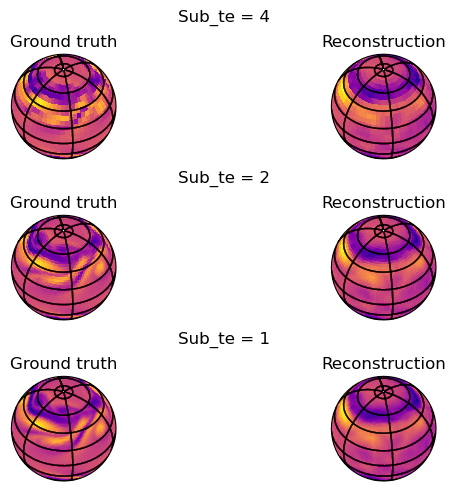

In [10]:
gif_baselines('/home/kassai/code/coral/visualizations/', 'predictions_deeponet_5%.gif', preds, truths, channel = 1, view = (-10, 45))